<a href="https://colab.research.google.com/github/ChamodKalupahana/simulating_the_universe_using_GANs/blob/main/Conditional_Implict_Cham_Diffusion_Model_with_2_channel_U_net_for_N_body_to_hydro_to_generate_unshuffled_evaluation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Implict Cham-Diffusion Model with 2-channel U-net for N-body to hydro to generate unshuffled evaluation maps (IllusrisTNG maps)



ONLY NEED TO REPLACE FILE PATHS AT START AND RUN FOR 20 EPOCHS

SAVE ALL IMAGES AND MSE VALUES

### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import math
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import layers

N_body_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mtot_Nbody_IllustrisTNG_LH_z=0.00.npy'

# REMEMBER TO CHECK THESE FLIE PATHS
hydro_field_file_path_IllustrisTNG = '/content/drive/MyDrive/Colab Notebooks/CAMELs_test_data/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy'
total_predictions_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/cham_diffusion_IllustrisTNG_resdiual_u_net_20_epochs_M_cdm_predictions_1000_images'
total_hydro_truth_file_path = '/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/M_cdm_1000_images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Hyperparameters

In [ ]:
# data
num_epochs = 20
image_size = 256

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95
plot_diffusion_steps = 20

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 4 # only works for 4
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

### Define data

as one tf dataset


In [ ]:
def input_N_body_and_M_Z_IllustrisTNG_data_without_labels():

  global N_body_field_file_path_IllustrisTNG, N_body_field_file_path_SIMBA, hydro_field_file_path_IllustrisTNG, hydro_field_file_path_SIMBA
  # asinh mean of N_Body_IllustrisTNG dataset = 26.00409
  N_body_dataset = np.arcsinh(np.load(N_body_field_file_path_IllustrisTNG))
  N_body_dataset = np.expand_dims((N_body_dataset) - np.mean(N_body_dataset), axis=3)

  # # np.log10 mean of M_Z_IllustrisTNG dataset = -6.6740975 (np.log10 produces correct lookings maps like in CAMELS examples)
  M_Z_dataset = np.log10(np.load(hydro_field_file_path_IllustrisTNG))
  M_Z_dataset = np.expand_dims((M_Z_dataset) - np.mean(M_Z_dataset), axis=3)

  # use commented code if np.log10 doesn't work
  
  # Mstar_dataset = np.arcsinh(np.load(hydro_field_file_path_IllustrisTNG))
  # Mstar_dataset = np.expand_dims((Mstar_dataset) - np.mean(Mstar_dataset), axis=3)
  # Mstar_dataset = Mstar_dataset / (np.max(np.abs(Mstar_dataset)))
  # N_body_dataset = N_body_dataset / (np.max(np.abs(N_body_dataset)))
  # full_dataset = tf.data.Dataset.from_tensor_slices((N_body_dataset, Mstar_dataset))

  #10.089378 for full N-body dataset
  N_body_dataset = N_body_dataset / (np.max(np.abs(N_body_dataset))) # so that pixels are in range [-1,1]
  M_Z_dataset = M_Z_dataset / (np.max(np.abs(M_Z_dataset)))

  full_dataset = tf.data.Dataset.from_tensor_slices((N_body_dataset, M_Z_dataset))

  return full_dataset

ds = input_N_body_and_M_Z_IllustrisTNG_data_without_labels()

In [ ]:
def preprocess_image(train_image, truth_image):
    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    train_image = tf.image.resize(train_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    train_image = train_image - tf.keras.backend.min(train_image)
    train_image = train_image / tf.keras.backend.max(train_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    truth_image = tf.image.resize(truth_image, size=[image_size, image_size], antialias=True)

    # rescale pixels to [0, 1] range
    truth_image = truth_image - tf.keras.backend.min(truth_image)
    truth_image = truth_image / tf.keras.backend.max(truth_image) #tf.clip_by_value(image / 255.0, 0.0, 1.0) loses infomation

    return train_image, truth_image 

x_train = (
    ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    #.shuffle(batch_size * 2)
    .prefetch(tf.data.AUTOTUNE)
)

(4, 256, 256, 1)


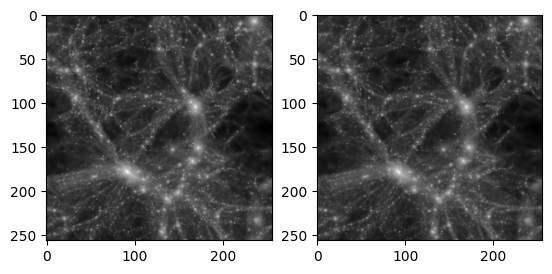

In [ ]:
# check training data
test = tfds.as_numpy(x_train)
test = iter(test)
train_batch, truth_batch = next(test)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_batch[0], cmap='gray')
ax[1].imshow(truth_batch[0], cmap='gray')
print(np.shape(truth_batch))

# free up memory
del ds, test

### Define Residual U-net with time embeddings

In [ ]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 1), name='M_Z_maps') # noisy M_Z maps
    input_images =  keras.Input(shape=(image_size, image_size, 1), name='N_body_maps') # N-body maps
    noise_variances = keras.Input(shape=(1, 1, 1), name='time_embeddings')

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    x = layers.Concatenate()([x, input_images])

    skips_x = []
    skips_y = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips_x])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips_x])

    x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)# changed filters from 3 to 1

    return keras.Model([noisy_images, input_images, noise_variances], x, name="residual_unet")

### Define Guassian Diffusion model

In [ ]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()
        
        self.normalizer_x = layers.Normalization(mean=0.212272, variance=0.01243266) # for input images, pre-computed for N-body IllutriusTNG and SIBMA
        
        # REPLACE MEAN AND VARIANCE VALUES BELOW
        self.normalizer_y = layers.Normalization(mean=0.47959432, variance=0.12582532) # for truth images, pre=computed for M_Z IllutriusTNG and SIBMA

        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker] #removed self.kid

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        #images = self.normalizer_x.mean + images * self.normalizer_x.variance**0.5
        #mean, variance = 0.212272, 0.01243266 # pre-computed from before for M_Z maps
        mean = 0.47959432
        variance = 0.12582532 # for M_Z (doesn't work for other fields)
        images = mean + images * variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, input_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, input_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, input_images,diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, input_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, input_images, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        #initial_noise = tf.random.normal(mean=(self.normalizer_x.variance * tf.math.log(input_images)), stddev=self.normalizer_x.variance, shape=(num_images, image_size, image_size, 1)) # changed 3 to 1
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 1)) # changed 3 to 1

        generated_images = self.reverse_diffusion(initial_noise, input_images, diffusion_steps) # input_images not used
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images): # added y input to images
        # normalize images to have standard deviation of 1, like the noises
        input_images, images = images # unpack data

        images = self.normalizer_x(images, training=True)
        input_images = self.normalizer_x(input_images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 1)) # changed 3 to 1

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(noisy_images, input_images, noise_rates, signal_rates, training=True)

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images): # added y input to images
        # normalize images to have standard deviation of 1, like the noises
        input_images, images = images # unpack data

        images = self.normalizer_x(images, training=False)
        input_images = self.normalizer_y(input_images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 1)) # changed 3 to 1

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # concatenate truth_images to noisy_images
        noisy_images = noisy_images + input_images

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, input_images, num_of_images_for_generate,epoch=None, logs=None):
        # plot random generated images for visual evaluation of generation quality
        input_images = self.normalizer_x(input_images, training=False)
        generated_images = self.generate(
            input_images = input_images,
            num_images=num_of_images_for_generate,
            diffusion_steps=plot_diffusion_steps,
        )

        return generated_images


In [ ]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)


model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

checkpoint_path = "256_training_copy/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model weights (doesn't work)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='n_loss',
                                                 mode='min',
                                                 verbose=2,
                                                 save_best_only=True)

#define val data
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

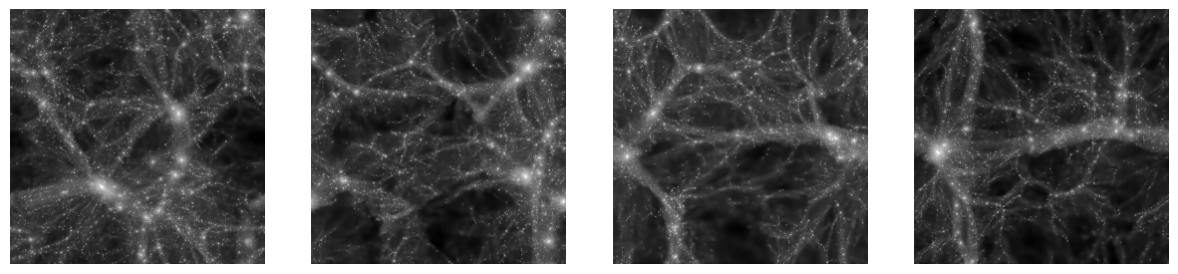

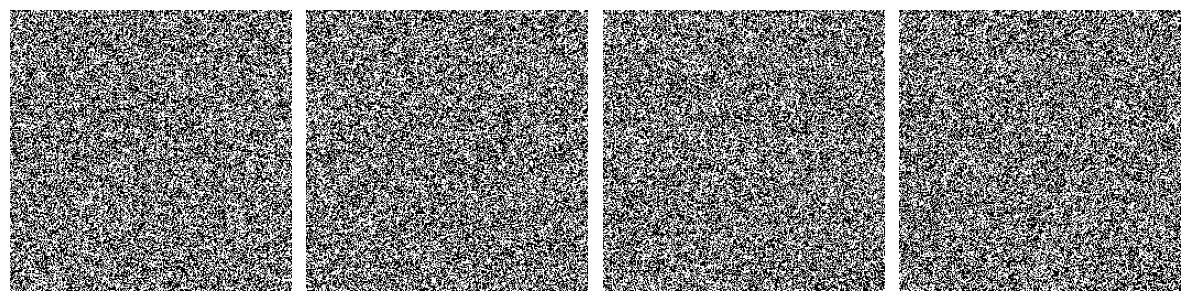

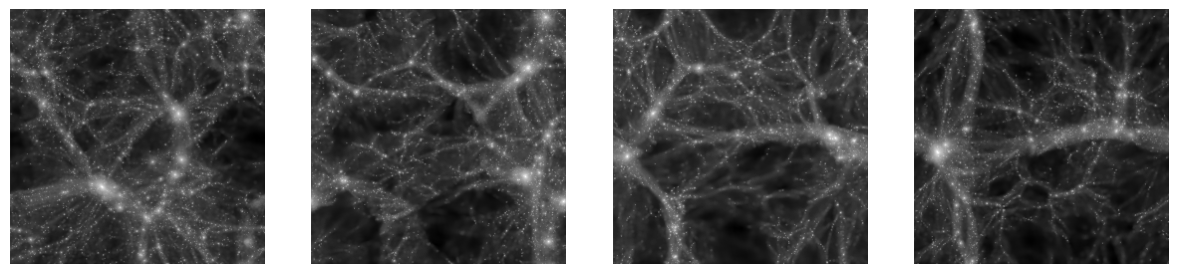

In [ ]:
# plot first 4 prediction maps before training

N = np.shape(test_batch)[0] # only works for 4
if batch_size > 4:
  N = 4

# plot input mpas
fig, ax = plt.subplots(1, N, figsize=(12, 5))
for i in range(0, N):
  fig.tight_layout()
  ax[i].axis("off")
  ax[i].imshow(test_batch[i], cmap='gray')
plt.show()

# plot prediction maps
num_of_images_for_generate = batch_size # fix later
generated_images = model.plot_images(test_batch, num_of_images_for_generate)

# plotting infomation
fig, ax = plt.subplots(1, N, figsize=(12, 5))
for i in range(N):
        fig.tight_layout()
        ax[i].axis("off")
        ax[i].imshow(generated_images[i], cmap='gray')
plt.tight_layout()
plt.show()
plt.close()

# plot ground truth maps
fig, ax = plt.subplots(1, N, figsize=(12, 5))
for i in range(0, N):
  fig.tight_layout()
  ax[i].axis("off")
  ax[i].imshow(truth_batch[i], cmap='gray')
plt.show()

### Training

In [ ]:
model.fit( # 2 epochs done
    x_train,
    epochs=num_epochs)

Epoch 1/20
3750/3750 [==============================] - 163s 38ms/step - n_loss: 0.1209
Epoch 2/20
3750/3750 [==============================] - 142s 38ms/step - n_loss: 0.0977
Epoch 3/20
3750/3750 [==============================] - 142s 38ms/step - n_loss: 0.0925
Epoch 4/20
3750/3750 [==============================] - 142s 38ms/step - n_loss: 0.0896
Epoch 5/20
3750/3750 [==============================] - 143s 38ms/step - n_loss: 0.0875
Epoch 6/20
3750/3750 [==============================] - 143s 38ms/step - n_loss: 0.0872
Epoch 7/20
3750/3750 [==============================] - 145s 39ms/step - n_loss: 0.0855
Epoch 8/20
3750/3750 [==============================] - 145s 39ms/step - n_loss: 0.0849
Epoch 9/20
3750/3750 [==============================] - 144s 38ms/step - n_loss: 0.0852
Epoch 10/20
3750/3750 [==============================] - 144s 38ms/step - n_loss: 0.0841
Epoch 11/20
3750/3750 [==============================] - 144s 38ms/step - n_loss: 0.0849
Epoch 12/20
3750/3750 [=======

### Test model

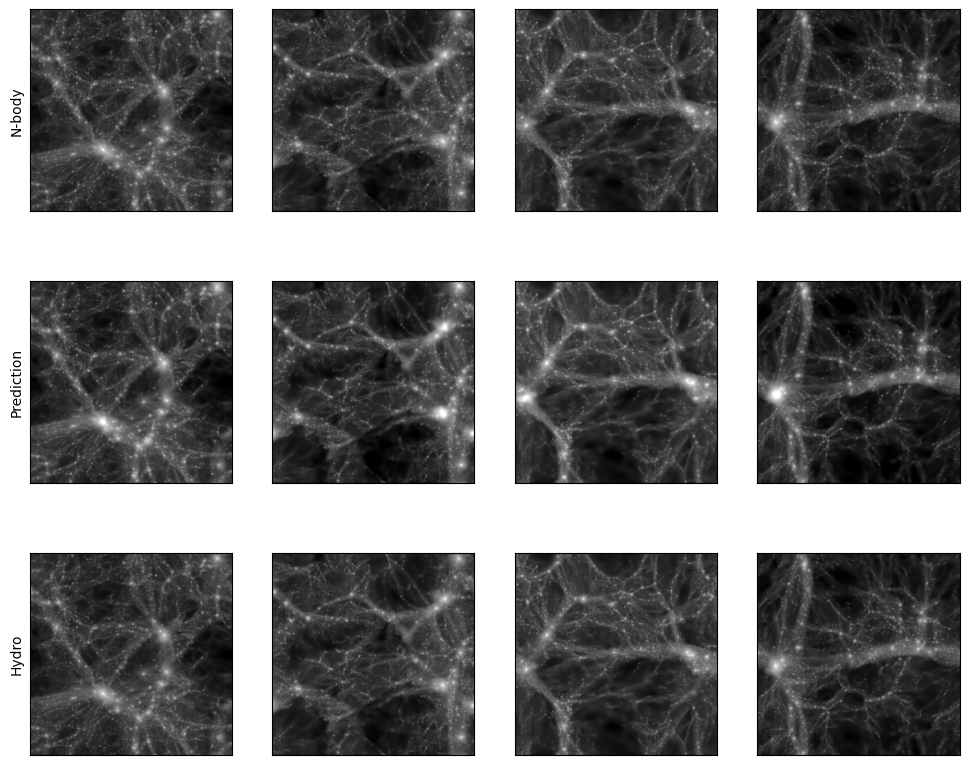

In [ ]:
N = np.shape(test_batch)[0]
if batch_size > 4:
  N = 4

num_of_images_for_generate = batch_size
generated_images = model.plot_images(test_batch, num_of_images_for_generate)


rows = 3
columns = 4
fig, ax = plt.subplots(rows,columns, figsize=(12, 10))
#fig.tight_layout()
#ax[row, column]

for column in range(columns):
    ax[0, column].imshow(test_batch[column], cmap='gray')
    ax[1, column].imshow(generated_images[column], cmap='gray')
    ax[2, column].imshow(truth_batch[column], cmap='gray')

    ax[0, 0].set_ylabel('N-body')
    ax[1, 0].set_ylabel('Prediction')
    ax[2, 0].set_ylabel('Hydro')
    for row in range(rows):
      #ax[row, column].axis("off")
      ax[row, column].set_xticks([])
      ax[row, column].set_yticks([])

Text(0.5, 1.0, 'Hydro')

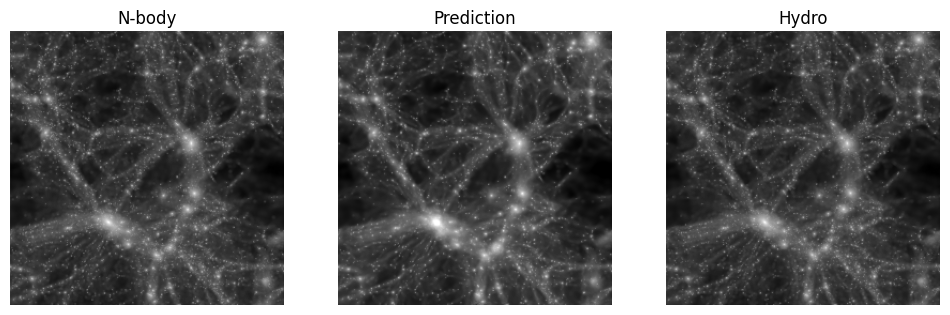

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(test_batch[0], cmap='gray')
ax[1].imshow(generated_images[0], cmap='gray')
ax[2].imshow(truth_batch[0], cmap='gray')

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

ax[0].set_title('N-body')
ax[1].set_title('Prediction')
ax[2].set_title('Hydro')

# ax[0].set_title('N-body ($M_{tot}$)')
# ax[1].set_title('Prediction')
# ax[2].set_title('Gas Metallicity ($M_Z$)')

Text(0.5, 1.0, 'Residual from Prediction')

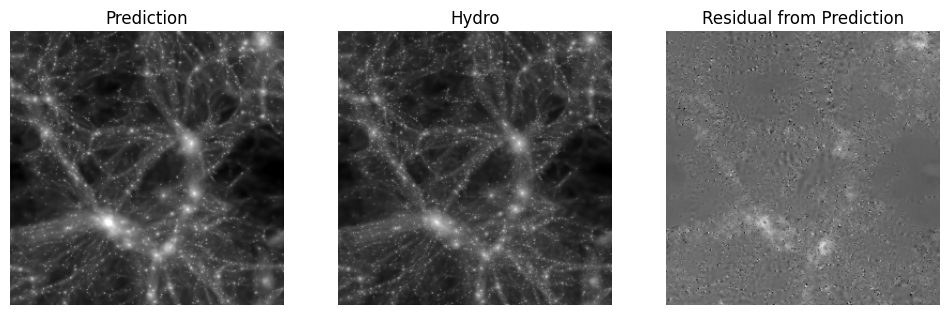

In [ ]:
# find difference in prediction and truth
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

noise_error = (generated_images[0] - truth_batch[0])

ax[0].imshow(generated_images[0], cmap='gray')
ax[1].imshow(truth_batch[0], cmap='gray')
ax[2].imshow(noise_error, cmap='gray')

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

ax[0].set_title('Prediction')
ax[1].set_title('Hydro')
ax[2].set_title('Residual from Prediction')

In [ ]:
# # check predictions are condiditoned
# for loop in range(3):
#   num_of_images_for_generate = batch_size
#   generated_images = model.plot_images(test_batch, num_of_images_for_generate)

#   # plotting infomation
#   N = 4
#   fig, ax = plt.subplots(1, N, figsize=(12, 5))
#   for i in range(N):
#           fig.tight_layout()
#           ax[i].axis("off")
#           ax[i].imshow(generated_images[i], cmap='gray')
#   plt.tight_layout()
#   plt.show()
#   plt.close()

### Save images

In [ ]:
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

num_of_saved_images = 1000 # must be mutiple of 4 (batch_size)
total_N_body_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_prediction_maps = np.zeros([num_of_saved_images, 256, 256, 1])
total_hydro_maps = np.zeros([num_of_saved_images, 256, 256, 1])

for index in range(4, num_of_saved_images, 4):
  generated_images = model.plot_images(test_batch, num_of_images_for_generate)

  # save images in arrays
  total_N_body_maps[index-4:index, :,:,:] = test_batch
  total_prediction_maps[index-4:index, :,:,:] = generated_images
  total_hydro_maps[index-4:index, :,:,:] = truth_batch

  test_batch, truth_batch = next(test)


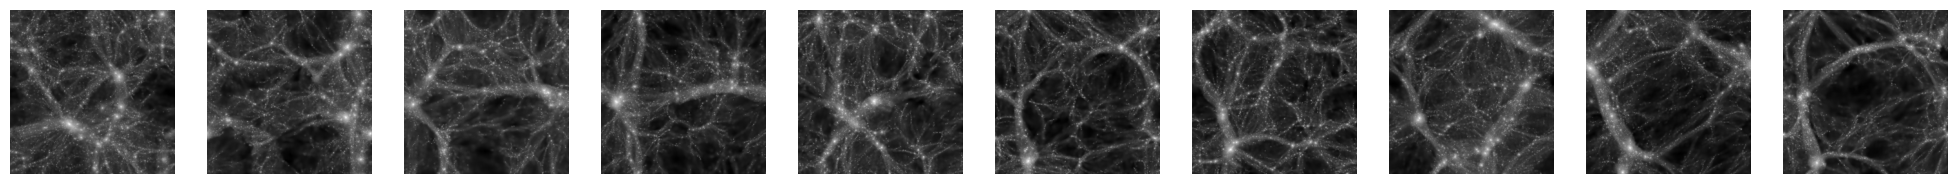

In [ ]:
# n-body graphs should match
columns = 10

fig, ax = plt.subplots(1, columns, figsize=(25, 5))

for column in range(columns):
  ax[column].imshow(total_N_body_maps[column], cmap='gray')
  ax[column].axis('off')

In [ ]:
np.shape(total_prediction_maps)

(1000, 256, 256, 1)

In [ ]:
#np.save('/content/drive/MyDrive/Colab Notebooks/Results/Unshuffled data/N_body_1000_images', total_N_body_maps)
np.save(total_predictions_file_path, total_prediction_maps)
np.save(total_hydro_truth_file_path, total_hydro_maps)

### Calculate mean squared error

In [ ]:
# quick method
num_of_saved_images = 1000 # for 15000 images with batch_size 4, takes around 1hr, num_of_batches = 3749

prediction_error = np.sum(((total_prediction_maps - total_hydro_maps)**2) / (65536 * 250))

print('MSE per pixel between prediction and M_Z maps: {total_error:.4f}'.format(total_error = prediction_error))
print(np.shape(prediction_error))

MSE per pixel between prediction and M_Z maps: 0.0041
()


In [ ]:
# re-generate images
num_of_saved_images = 1000 # for 15000 images with batch_size 4, takes around 1hr, num_of_batches = 3749
total_prediction_error = np.array([])

# reset iterator
test = tfds.as_numpy(x_train)
test = iter(test)
test_batch, truth_batch = next(test)

for index in range(num_of_saved_images):
  generated_images = model.plot_images(test_batch, num_of_images_for_generate)

  prediction_error = np.sum((generated_images - truth_batch)**2) / 65536
  total_prediction_error = np.append(total_prediction_error, prediction_error)

  test_batch, truth_batch = next(test)

total_prediction_error_mean = np.mean(total_prediction_error)
print('MSE per pixel between prediction and M_Z maps: {total_error:.4f}'.format(total_error = total_prediction_error_mean))
print(np.shape(total_prediction_error))

MSE per pixel between prediction and M_Z maps: 0.0041
(1000,)


In [ ]:
print(1/0)

ZeroDivisionError: ignored